In [3]:
fp = '/home/theo/research/courses/12.843' # path for data

In [4]:
import xarray as xr
import scipy.io as sio
from scipy.fft import fft, ifft
from matplotlib.path import Path
import pickle
from scipy.stats import pearsonr
from os.path import join
import numpy as np
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
from copy import deepcopy
    
### Specify figure resolution
scale = 1
mpl.rcParams['figure.dpi']        = 150 # set figure resolution (dots per inch) 
mpl.rcParams['hatch.linewidth']   = .15  * scale
mpl.rcParams['axes.labelsize']    = 11  * scale
mpl.rcParams['axes.titlesize']    = 13  * scale
mpl.rcParams['xtick.labelsize']   = 9   * scale
mpl.rcParams['ytick.labelsize']   = 9   * scale
mpl.rcParams['lines.linewidth']   = 1   * scale
mpl.rcParams['legend.fontsize']   = 8   * scale
mpl.rcParams['patch.linewidth']   = 1   * scale
mpl.rcParams['contour.linewidth'] =.5   * scale
mpl.rcParams['axes.labelpad']     = 4 * scale   # space between label and axis
mpl.rcParams['xtick.major.pad']   = 0 * scale   # distance to major tick label in points
mpl.rcParams['ytick.major.pad']   = mpl.rcParams['xtick.major.pad']
mpl.rcParams['lines.markersize']  = 3 * scale

### cartopy-specific parameters
gridline_width                    = .7 * scale
border_width                      = .3 * scale

### manually specified colorbar params
tick_width                        = 0 * scale # controls size of tickmark next to labels
tick_length                       = 2 * scale

$\zeta = \frac{1}{R\cos{\theta}}\Big[\frac{\partial}{\theta}\left(u\cos{\theta}\right) - \frac{\partial v}{\partial \phi}\Big]$

$\zeta = \frac{1}{R\cos{\theta}} \Big[\frac{\partial}{\partial\theta}\left(u\cos{\theta}\right)- \frac{\partial v}{\partial \phi}\Big]$

convert coords to polar (i.e. deg 2 rad)

In [6]:
u = xr.open_dataset(join(fp, 'era5_u_843.nc')).u.sel(latitude=slice(50,0),longitude=slice(220,260)).compute()
v = xr.open_dataset(join(fp, 'era5_v_843.nc')).v.sel(latitude=slice(50,0),longitude=slice(220,260)).compute()

lon = deepcopy(u.longitude)
lat = deepcopy(u.latitude)

theta = np.deg2rad(u.latitude)
phi   = np.deg2rad(u.longitude)

u['longitude'] = phi
v['longitude'] = phi

u['latitude']  = theta
v['latitude']  = theta

u0 = deepcopy(u)
v0 = deepcopy(v)

R = 6.37e6
dv_dphi             = -v0.differentiate('longitude')
u_cos_theta         = u0 * np.cos(u0.latitude)

dtheta_du_cos_theta = -u_cos_theta.differentiate('latitude')
zeta                = 1 / (R*np.cos(u0.latitude)) * (dtheta_du_cos_theta - dv_dphi)
zeta = zeta.compute()

In [93]:
idx = np.argsort(zeta.isel(level=1,time=0).stack(n=['latitude','longitude']).values)
zeta.isel(level=1,time=0).stack(n=['latitude','longitude']).values[idx[-5:]]

array([0.00051895, 0.00052834, 0.0005321 , 0.00053226, 0.00054353],
      dtype=float32)

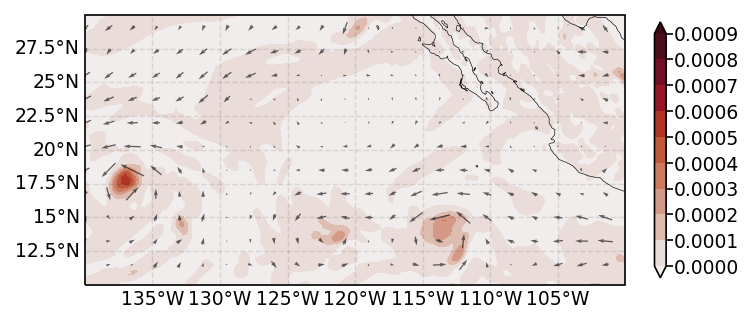

In [9]:
t=40
for t in range(len(u.time)):
    figsize=(5,4)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([220,260,10,30], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=border_width)
    ax.add_feature(cfeature.BORDERS, zorder=1, linewidth = border_width)
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=.1, linewidth=gridline_width, color='k', zorder=1.05)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': mpl.rcParams['xtick.labelsize']}
    gl.ylabel_style = {'size': mpl.rcParams['ytick.labelsize']}

    cp1 = ax.contourf(lon,lat, zeta.isel(time=t, level=1),                  
                      extend='both',  cmap='cmo.amp', levels=np.arange(0,10e-4,10e-5),transform=ccrs.PlateCarree())
    cb = fig.colorbar(cp1, fraction=.02)

    #### Quiver plot
    n=7
    x,y = np.meshgrid(lon[::n].values, lat[::n].values)
    qv = ax.quiver(x,y, u.isel(time=t, level=1).values[::n,::n], v.isel(time=t, level=1).values[::n,::n], scale=.5e3,
                   color='black', alpha=.6, transform=ccrs.PlateCarree(), pivot='middle')
    fig.savefig(f'lab-figs/zoomed_{t:03d}.png')
    plt.close(fig)
    plt.show()
    break